In [1]:
import torch
torch.__version__

'2.1.2+cpu'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.version.cuda

(device(type='cpu'), None)

In [3]:
import os

if torch.cuda.is_available():
    if not os.environ.get('CUBLAS_WORKSPACE_CONFIG', False):
        os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
else:
    if os.environ.get('CUBLAS_WORKSPACE_CONFIG', False):
        del os.environ['CUBLAS_WORKSPACE_CONFIG']

os.environ.get('CUBLAS_WORKSPACE_CONFIG', None)

In [4]:
torch.set_default_device(device)
torch.set_default_dtype(torch.float)
torch.backends.cudnn.benchmark = torch.cuda.is_available()
torch.backends.cudnn.deterministic = torch.cuda.is_available()
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.enabled = torch.cuda.is_available()

In [5]:
import numpy as np
import random

SEED = 3407 #torch.seed()
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed()
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator(device=device)
g.manual_seed(SEED)

SEED, g.device, g.initial_seed()

(3407, device(type='cpu'), 3407)

In [6]:
import pandas as pd 

df = pd.read_csv("/kaggle/input/squats/data.csv")
df.head()

,filename,bending forward,heels lifting,knees caving,no depth,olympic squat,powerlifting squat,toes lifting
0,recording_02052023_120247,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,recording_02052023_120254,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,recording_02052023_120301,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,recording_02052023_120323,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,recording_02052023_120333,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.model_selection import train_test_split

pl_squat_df = df[df['powerlifting squat']==1].copy()
X_train, X_test = train_test_split(pl_squat_df, random_state=SEED, test_size=0.2, shuffle=True)
X_train = X_train.sample(100, random_state=SEED, replace=True)
X_train.to_csv("pl_train.csv", index=False)
X_test.to_csv("pl_test.csv", index=False)

In [9]:
from utils.dataset import SquatDataset
from pathlib import Path

BASE = Path.cwd()
DATA = BASE.parent / "input"/ "squats"/ "data"
TRAIN = BASE / "pl_train.csv"
TEST = BASE / "pl_test.csv"

train_dataset = SquatDataset(csv_file=TRAIN, root_dir=DATA, device=device)
test_dataset = SquatDataset(csv_file=TEST, root_dir=DATA, device=device)
len(train_dataset), len(test_dataset)

(100, 48)

In [10]:
from torch.utils.data import DataLoader

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

def seed_worker(worker_id):
    worker_seed = torch.cuda.initial_seed() if torch.cuda.is_available()\
                    else torch.initial_seed()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False,
                              num_workers=0, worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [14]:
from utils.angles import angle_between_lines

tensor_a = torch.tensor([1, 2, 3]).type(torch.float)
tensor_b = torch.tensor([4, 5, 6]).type(torch.float)
tensor_c = torch.tensor([7, 8, 9]).type(torch.float)
tensor_d = torch.tensor([10, 11, 12]).type(torch.float)

angle = angle_between_lines(tensor_a, tensor_b, tensor_c)
angle

tensor(0.)

In [15]:
data_dict = train_dataset[0]
data = data_dict.get("data")
mask = (data != -1).any(dim=1)
data = data[mask]

In [52]:
from utils.angles import AOI, gaussian_smooth

smoothed_data = gaussian_smooth(data.reshape(-1, 19, 3), sigma=1.41)
angles = [torch.tensor([angle_between_lines(frame[joints[0]], frame[joints[1]], frame[joints[2]]) for joints in AOI])\
             for frame in smoothed_data]
angles_smooth = torch.cat(angles).reshape(-1, 12)

# Training

In [55]:
from utils.checkpoint import Checkpoint
from models.regression import RegressionModel
from torch import nn
from tqdm.auto import tqdm

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
error = nn.L1Loss()
model = RegressionModel().to(device)
checker = Checkpoint(default=float('inf'), path="artifacts")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-7) 

w = 18
model.train()
for epoch in tqdm(range(500), position=0):
    losses = []
    optimizer.zero_grad()
    for i in range(angles_smooth.shape[0]):
        if w+i+1 > angles_smooth.shape[0]:
            break
        X, y = angles_smooth[i:w+i], angles_smooth[1+i:w+i+1]
        logits = model(X)
        loss = error(logits, y)
        loss.backward()
        losses.append(loss.item())
    
    optimizer.step()
    full_loss = sum(losses)/len(losses)
    benchmark = checker.save_best(loss=full_loss, model=model, \
                                      optimizer=optimizer, epoch=epoch, \
                                      seed=SEED)
    if (epoch+1)%100==0:
        print(f"Epoch {epoch+1}", "Loss: ", full_loss, " Benchmark: ", benchmark)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 100 Loss:  0.05364987254142761  Benchmark:  0.05364987254142761
Epoch 200 Loss:  0.054889627152456426  Benchmark:  0.03871901881582332
Epoch 300 Loss:  0.07022767640509696  Benchmark:  0.03151040657792451
Epoch 400 Loss:  0.03174841358273659  Benchmark:  0.027363716747682048
Epoch 500 Loss:  0.0379040954318249  Benchmark:  0.020888389176074065


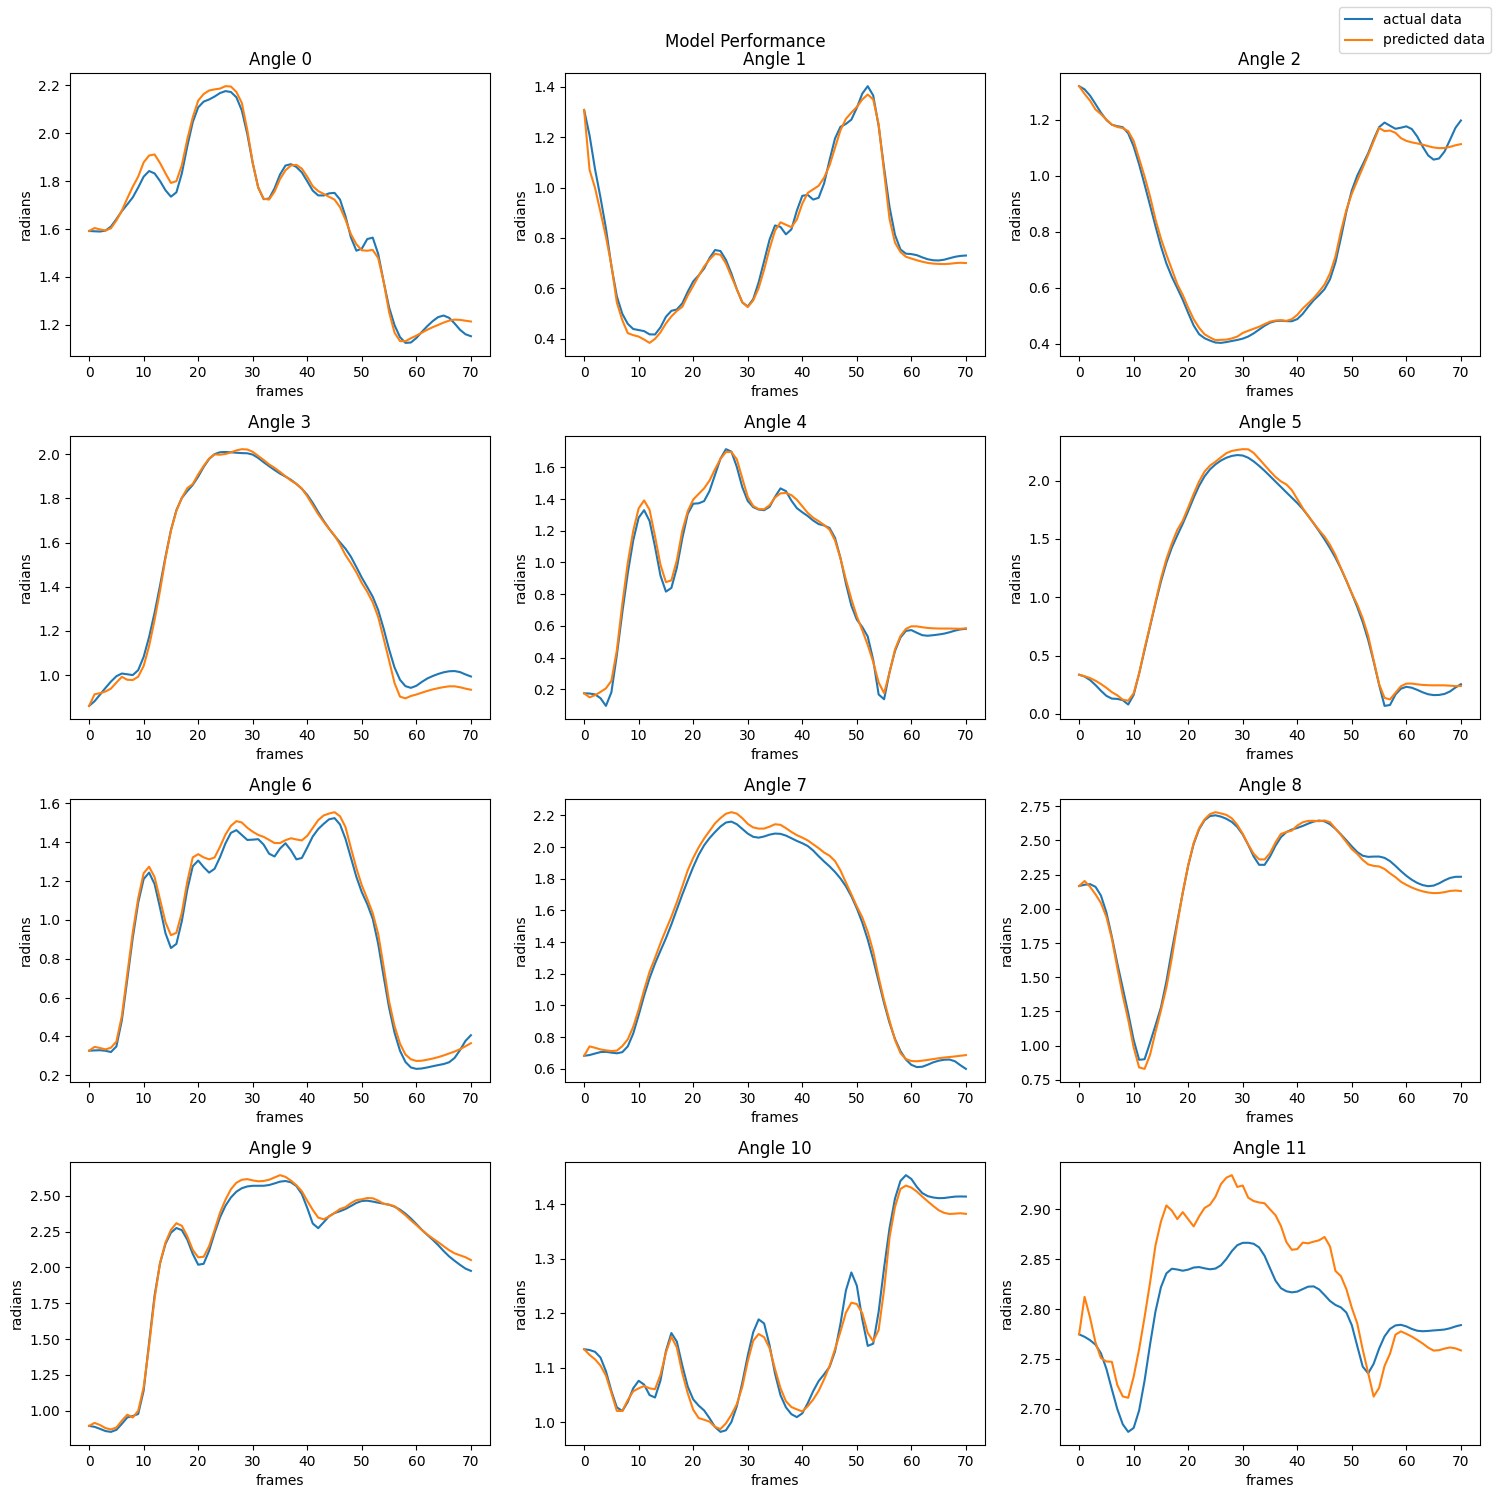

<Figure size 640x480 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
from utils.trend_inference import inference

model = RegressionModel().to(device)
checkpoint = torch.load(("artifacts", f"{model.__class__.__name__}.pt"))
model.load_state_dict(checkpoint["model"])

c = inference(model, angles_smooth)
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Model Performance')
count = 0
for i in range(4):
    for j in range(3):
    #     plt.plot(angles[:, i].cpu().numpy())
        ax[i, j].plot(angles_smooth[:, count].cpu().numpy())
        ax[i, j].plot(c[:, count].cpu().numpy())
        ax[i, j].set(xlabel='frames', ylabel='radians')
        ax[i, j].title.set_text(f"Angle {count}")
        count += 1
fig.legend(['actual data', 'predicted data'])
plt.tight_layout()
plt.show()
plt.savefig("Angles.png", dpi=400)

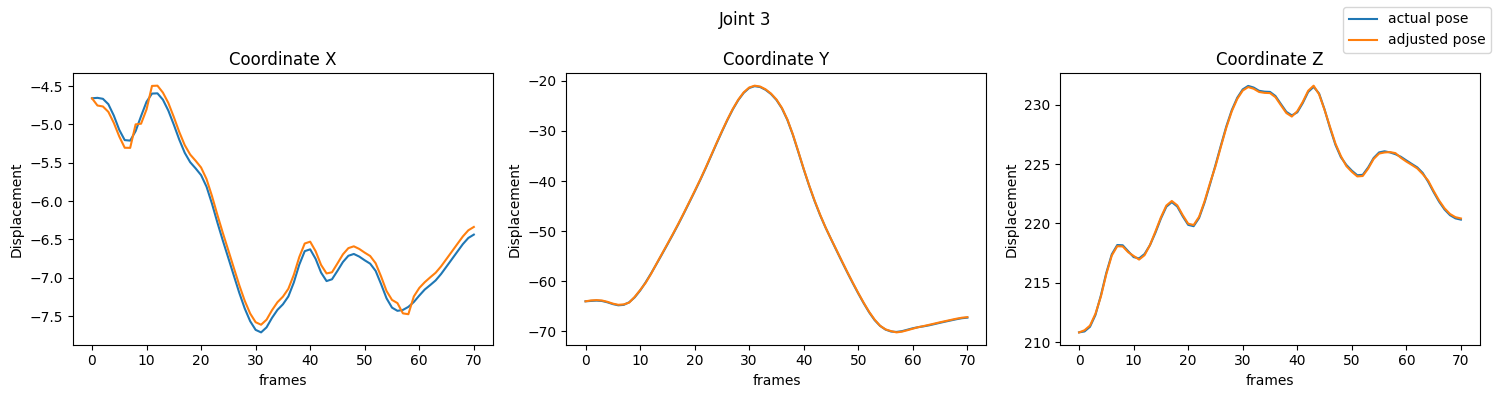

<Figure size 640x480 with 0 Axes>

In [143]:
from utils.angles import plot_points
from utils.angles import ik_transform

joint=3
adjusted_points = ik_transform(smoothed_data, data, c)
X_real, Y_real, Z_real, X_adj, Y_adj, Z_adj = plot_points(real_data=smoothed_data, \
                                                          adj_data=adjusted_points, joint=joint)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f"Joint {joint}")
j = 0
for name, axis in zip(["X", "Y", "Z"], [(X_real, X_adj), (Y_real, Y_adj), (Z_real, Z_adj)]):
    real, adj = axis
    ax[j].plot(np.array(real),)#linestyle='dashed')
    ax[j].plot(np.array(adj),)# linestyle='dotted')
    ax[j].set(xlabel='frames', ylabel=f"Displacement")
    ax[j].title.set_text(f"Coordinate {name}")
    j += 1

fig.legend(["actual pose", "adjusted pose"])
plt.tight_layout()
plt.show()
plt.savefig(f"joint {joint}.png", bbox_inches="tight", dpi=400)

# For all squats

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

w = 18
model = RegressionModel().to(device)
error = nn.L1Loss()
checker = Checkpoint(default=float('inf'), path="artifacts")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7) 
model.train()
for epoch in tqdm(range(100), position=0):
    all_losses = []
    optimizer.zero_grad()
    for data_dict in tqdm(train_dataset, position=1):
        data = data_dict.get("data")
        mask = (data != -1).any(dim=1)
        data = data[mask]
        smoothed_data = gaussian_smooth(data.reshape(-1, 19, 3), sigma=1.5)
        angles = [torch.tensor([angle_between_lines(frame[joints[0]], frame[joints[1]], frame[joints[2]]) for joints in AOI])\
                     for frame in smoothed_data]
        angles_smooth = torch.cat(angles).reshape(-1, 12)
        losses = []
        for i in range(angles_smooth.shape[0]):
            if w+i+1 > angles_smooth.shape[0]:
                break
            X, y = angles_smooth[i:w+i], angles_smooth[1+i:w+i+1]
            logits = model(X)
            loss = error(logits, y)
            loss.backward()
            losses.append(loss.item())
        all_losses.append(sum(losses)/len(losses))
    optimizer.step()
    full_loss = sum(all_losses)/len(all_losses)
    benchmark = checker.save_best(loss=full_loss, model=model, \
                                      optimizer=optimizer, epoch=epoch, \
                                      seed=SEED)
    # if (epoch+1)%100==0:
    print(f"Epoch {epoch+1}", "Loss: ", full_loss, " Benchmark: ", benchmark)

0.08325008538696985
torch.Size([3042, 12]) torch.Size([186, 12]) torch.Size([168, 18, 12])


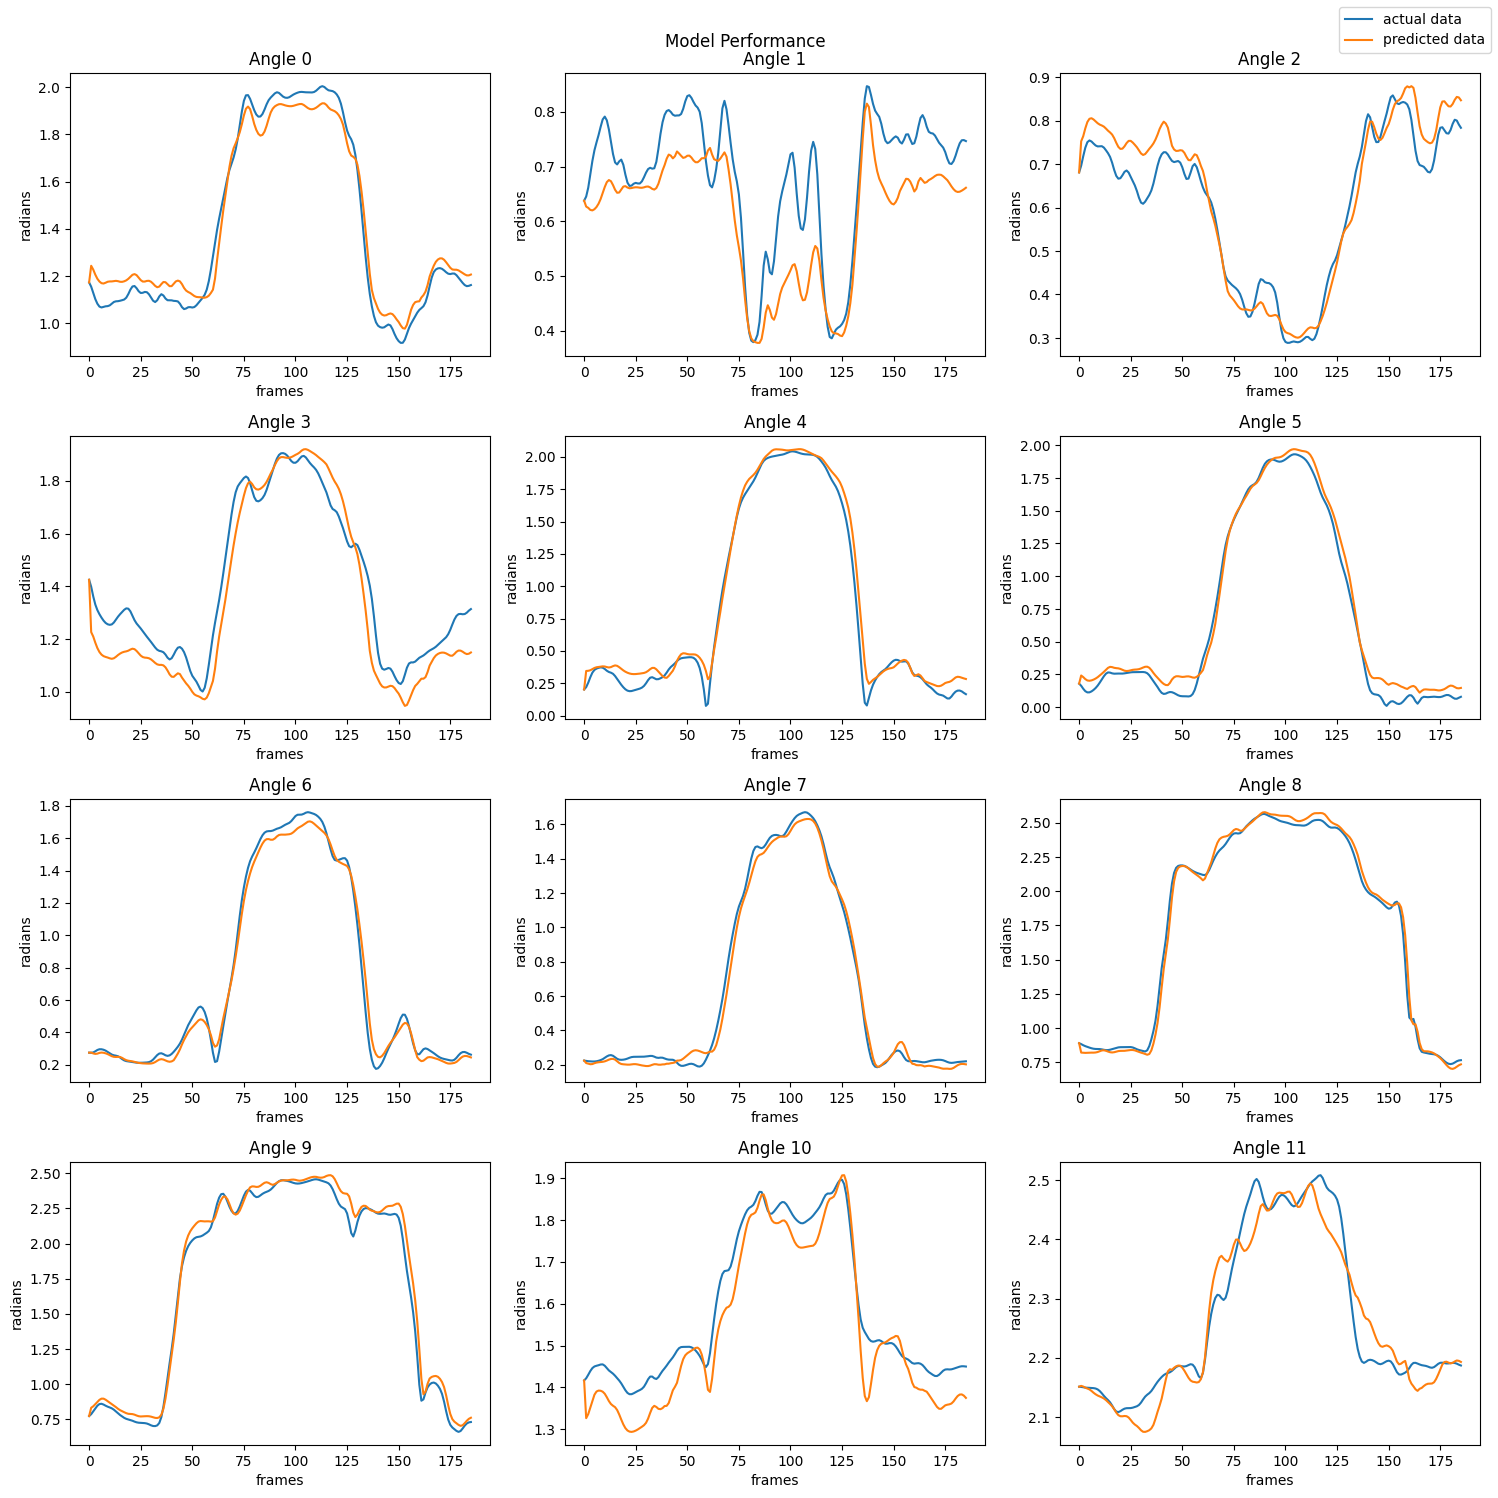

In [154]:
data = test_dataset[3].get("data")
mask = (data != -1).any(dim=1)
data = data[mask]
smoothed_data = gaussian_smooth(data.reshape(-1, 19, 3), sigma=1.5)
angles = [torch.tensor([angle_between_lines(frame[joints[0]], frame[joints[1]], frame[joints[2]]) for joints in AOI])\
             for frame in smoothed_data]
angles_smooth = torch.cat(angles).reshape(-1, 12)
c = inference(angles_smooth)
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Model Performance')
count = 0
for i in range(4):
    for j in range(3):
    #     plt.plot(angles[:, i].cpu().numpy())
        ax[i, j].plot(angles_smooth[:, count].cpu().numpy())
        ax[i, j].plot(c[:, count].cpu().numpy())
        ax[i, j].set(xlabel='frames', ylabel='radians')
        ax[i, j].title.set_text(f"Angle {count}")
        count += 1
fig.legend(['actual data', 'predicted data'])
plt.tight_layout()
plt.show()

In [155]:
adjusted_points = ik_transform(smoothed_data, data, c)

Iteration 0: loss = 0.05483757331967354 Gradients: 0.003136817831546068
Iteration 1: loss = 0.05287466570734978 Gradients: 0.0031440823804587126
Iteration 2: loss = 0.05101161450147629 Gradients: 0.0031350243370980024
Iteration 3: loss = 0.049251165241003036 Gradients: 0.0031408951617777348
Iteration 4: loss = 0.04757934436202049 Gradients: 0.00312593556009233
Iteration 5: loss = 0.046058539301157 Gradients: 0.0031212959438562393
Iteration 6: loss = 0.0446220263838768 Gradients: 0.0031169767025858164
Iteration 7: loss = 0.04326406121253967 Gradients: 0.0031136986799538136
Iteration 8: loss = 0.041975125670433044 Gradients: 0.0031196502968668938
Iteration 9: loss = 0.0407402366399765 Gradients: 0.00312471273355186
Adjusted points shape: torch.Size([186, 19, 3])


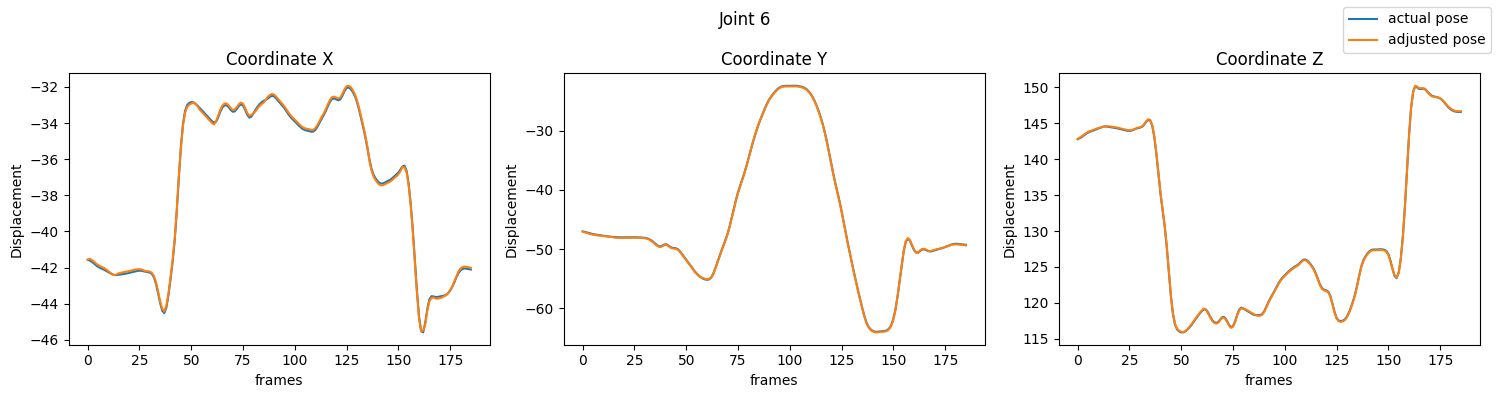

In [157]:
joint = 6
X_real, Y_real, Z_real, X_adj, Y_adj, Z_adj = plot_points(real_data=smoothed_data, \
                                                          adj_data=adjusted_points, joint=joint)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f"Joint {joint}")
j = 0
for name, axis in zip(["X", "Y", "Z"], [(X_real, X_adj), (Y_real, Y_adj), (Z_real, Z_adj)]):
    real, adj = axis
    ax[j].plot(np.array(real),)#linestyle='dashed')
    ax[j].plot(np.array(adj),)# linestyle='dotted')
    ax[j].set(xlabel='frames', ylabel=f"Displacement")
    ax[j].title.set_text(f"Coordinate {name}")
    j += 1

fig.legend(["actual pose", "adjusted pose"])
plt.tight_layout()
plt.show()